In [ ]:


# import all data from my drive
from google.colab import drive
drive.mount('/content/drive/')

path1 = '/content/drive/MyDrive/Data/male/85'
#path1 = '/content/drive/MyDrive/Admit card/Extra/My'


Mounted at /content/drive/


In [ ]:
download = "/content/drive/MyDrive/Data/male/85_new"
#num_image = 500

#epochs = 2500

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import imghdr
from PIL import Image
import time
from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import load_model, save_model
from sklearn.preprocessing import MinMaxScaler
import warnings
import random

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Reshape, Activation, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.optimizers import Adam

In [ ]:
'''
import numpy as np
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Extract only the images of 0 and their labels
images = x_train[y_train == 0]
labels = y_train[y_train == 0]

# Print the shape of the images and labels arrays
print(images.shape)
print(labels.shape)
'''

'\nimport numpy as np\nfrom tensorflow.keras.datasets import mnist\n\n# Load the MNIST dataset\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\n\n# Extract only the images of 0 and their labels\nimages = x_train[y_train == 0]\nlabels = y_train[y_train == 0]\n\n# Print the shape of the images and labels arrays\nprint(images.shape)\nprint(labels.shape)\n'

In [ ]:
folder = 0
# Define the image size (in pixels)
img_size = 28

# Initialize the arrays to store the images and labels
images = []
labels = []

# Loop through all the images in the folder
for filename in os.listdir(path1):
    # Get the label from the filename (assuming that the filename contains the label)
    label = filename[folder]
    #print(filename, label)

    # Read the image and resize it to the desired size
    img = cv2.imread(os.path.join(path1, filename))
    img = cv2.resize(img, (img_size, img_size))

    # Convert the image to grayscale and flatten it into a 1D array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = img.flatten()

    # Add the image and label to the arrays
    images.append(img)
    labels.append(label)

# Convert the arrays to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
labels

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U1')

In [ ]:
#train_images, train_labels, test_images, test_levels=train_test_split(images, labels, train_size = 1)
train_images, train_labels = images, labels

In [ ]:
train_images.shape

(1524, 28, 28)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 1232
BATCH_SIZE = 1024

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

   # upsample to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # upsample to 28x28
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

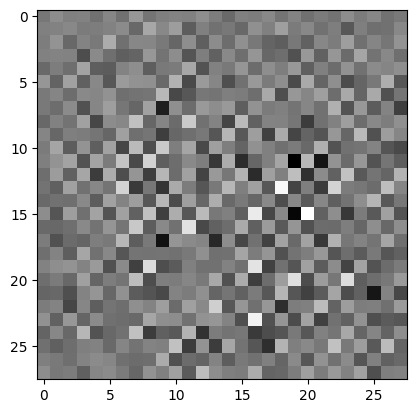

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) #a tensor with 100 value is created. So it can be generator's input
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#the generated image's shape is (1, 28, 28, 1). Where generated_image[0] and generated_image[-1] have to be 0.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    #model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())


    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49999416]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#from_logits=True means the loss function will work before it enter the sigmoid function

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    #tf.ones_like(real_output) will create shape of tensor situated in real output but all value inside that will be 1.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    #here all the real value will set as 1 and fake value set as 0. Then compare with predicted value
    total_loss = real_loss + fake_loss
    return total_loss
    #using binary cross entropy, loss function is created

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    #find generator loss with comparing fake output with ones_tensor of same shape

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#for generator and discriminator both case Adam optimizer is used and its learning rate is 0.0001

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 1

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#it creates random number with (num_examples_to_generate, noise_dim) dimension
#basically this part will go to the model

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    #BATCH_SIZE is number of row and noise_dim is number of column_

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #tf.GradientTape() find the gradiant or difference between 2 things
      generated_images = generator(noise, training=True)
      #get the noise and put it into generator function

      real_output = discriminator(images, training=True)
      #create weights and biases for real image and set output as 1
      fake_output = discriminator(generated_images, training=True)
      #from the previous weights and biases generate new output between 0 to 1


      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      #find out loss function for generator and discriminator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #find difference between gen_loss & generator.trainable_variables
    #or how much gen_loss is changed by changing the generator.trainable_variable one unit
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #find difference between disc_loss & discriminator.trainable_variables
    #or how much disc_loss is changed by changing the discriminator.trainable_variables one unit

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #optimizer to reduce difference between gradients_of_generator & generator.trainable_variables
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    #optimizer to reduce difference between gradients_of_discriminator & discriminator.trainable_variables

In [ ]:
def train(dataset, epoch):
  for epoch in range(epoch):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      #save the path to the file_prefix

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    #print how much time is needed do each step

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epoch,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

# if i want to make the images as subplot
###  for i in range(predictions.shape[0]):
###      plt.subplot(4, 4, i+1)
###      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
###      plt.axis('off')

#if i want to make the images to show one by one
  for i in range(predictions.shape[0]):
    plt.figure()
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

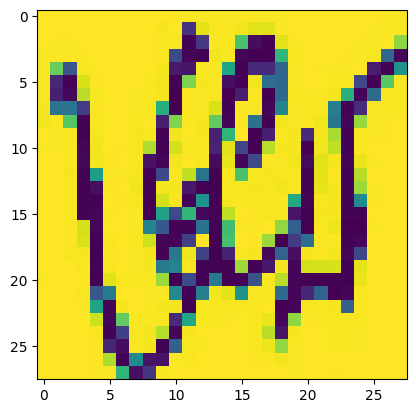

In [ ]:
plt.imshow(images[50])

<Figure size 400x400 with 0 Axes>

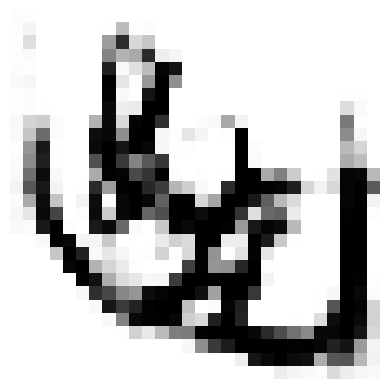

Time for epoch 4669 is 0.7092320919036865 sec


In [ ]:
# Call the train function
train(train_dataset, EPOCHS)

In [ ]:
# Set the directory path
dir_path = "/content/"

# Get a list of all the filenames in the directory
file_list = os.listdir(dir_path)

# Keep only the filenames that end with ".png" and have the desired suffix
suffix = ".png"
images_with_suffix = [f for f in file_list if f.endswith(suffix)]
images2 = images_with_suffix[:]

# Load the images into a NumPy array
images_array = np.array([np.array(Image.open(os.path.join(dir_path, f))) for f in images2]) #''' SO MUCH IMPORTANT FOR HOW MUCH PHOTO WE WILL USE '''



'''

# Set the directory path
dir_path = "/content/"

# Get a list of all the filenames in the directory
file_list = os.listdir(dir_path)

i = 5

images_list = []
for j in range(i):
    img = Image.fromarray((generated_images[j] * 255).astype(np.uint8))
    images_list.append(np.array(img))

# Convert list of images to NumPy ndarray
images_array = np.array(images_list)

# Save the last i images to disk
for j in range(i):
    filename = f"image_{j}.png"
    filepath = os.path.join(dir_path, filename)
    Image.fromarray(images_array[j]).save(filepath)
'''

In [ ]:
images_array.shape

In [ ]:
plt.imshow(images_array[-5])

In [ ]:
import urllib.request

dir_path = "/content/"
# Set the download path
download_path = download

# Loop through each filename in the images2 list and download the file
for filename in images2:
    url = "file://" + os.path.join(dir_path, filename)
    download_url = os.path.join(download_path, filename)
    urllib.request.urlretrieve(url, download_url)

In [ ]:
#print(output_images.shape)
print(generated_image.shape)
print(len(images2))

In [ ]:
import cv2
import numpy as np

# Assuming your input images are in a variable called images_array
# Reshape the input images to a compatible shape
images_array = images_array.reshape((-1, 480, 640, 4))  # adjust the dimensions if needed

# Resize each image to (28, 28) using OpenCV
resized_images = []
for i in range(len(images_array)):
    img = images_array[i]
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    resized_images.append(img)

# Convert the resized images to grayscale
gray_images = np.mean(resized_images, axis=-1, keepdims=True)

# Normalize the grayscale images
norm_images = gray_images / 255.0

# Convert the normalized images to the desired shape
output_images = norm_images.reshape((images_array.shape[0], 28, 28, 1))

In [ ]:
images2

In [ ]:
np.shape(output_images)

In [ ]:
plt.imshow(output_images[-1])

In [ ]:
decision = discriminator(output_images)
print (decision)